In [ ]:
import jax
import optax
import jax.numpy as jnp

from jax import random
from tqdm.auto import trange
from flax.training.train_state import TrainState
from distrax import Bernoulli

from genlearn.data import get_mnist_dataloaders
from genlearn.utils import count_params
from genlearn.models.vae import VAE

/Users/alexinch/Desktop/noodling/genlearn/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
trainloader, valloader = get_mnist_dataloaders()

In [15]:
def init_vae(trainloader, vae_params, seed=0):
    for x, _ in trainloader:
        break

    vae = VAE(**vae_params)

    params = vae.init(random.key(seed), x)
    print(f'{count_params(params):,} total parameters')
    print(jax.tree.map(jnp.size, params))

    return params, vae

In [16]:
@jax.jit
def train_step(state: TrainState, x: jnp.ndarray, *, rng, beta=1.0):
    """One SGD/Adam step."""
    def loss_fn(params):
        # forward
        x_hat, (q_mean, q_logvar) = state.apply_fn(
            params, x, rngs=rng
        )

        # reconstruction −E_q log p(x|z)
        recon = Bernoulli(probs=x_hat).log_prob(x).sum(axis=(1, 2))

        # KL between the prior over z and the posterior is analytic for diagonal Gaussians
        # KL(q‖p)  with p(z)=N(0, I), q(z|x)=N(μ, σ²I)
        kl = 0.5 * (q_mean**2 + jnp.exp(q_logvar) - 1.0 - q_logvar).sum(axis=1)

        # Our goal is the maximise the ELBO - so we'll take the negative loss
        return -jnp.mean(recon - beta * kl)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [ ]:
def setup_optimiser(trainloader, n_epochs=5):
    initial_lr = 0.0
    peak_lr = 3e-4
    batches_per_epoch = len(trainloader)
    total_steps = n_epochs * batches_per_epoch
    warmup_steps = total_steps // 10 # e.g., 10% of total steps for warmup

    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=initial_lr,
        peak_value=peak_lr,
        warmup_steps=warmup_steps,
        decay_steps=total_steps - warmup_steps,
        end_value=peak_lr * 0.01 # Decay to 1% of peak
    )

    tx = optax.adam(lr_schedule)
    return tx


def train_vae(trainloader, valloader, vae_params, n_epochs=5, beta=1.0):
    tx = setup_optimiser(trainloader, n_epochs)
    params, vae = init_vae(trainloader, vae_params)
    state = TrainState.create(apply_fn=vae.apply, params=params, tx=tx)

    batch_losses = []
    key = random.key(0)
    for _ in trange(n_epochs):
        for x, _ in trainloader:
            key, subkey = random.split(key)
            state, loss = train_step(state, x, rng=subkey, beta=beta)
            batch_losses.append(loss)
    
    return state, batch_losses

In [18]:
vae_params = {
    'enc_hidden_layers':[512, 256, 128, 64],
    'dec_hidden_layers':[64, 128, 256, 512],
    'latent_dim':10,
}
results = []
for beta in [1e-6, 1e-3, 1, 5, 10]:
    state, losses = train_vae(trainloader, valloader, vae_params, n_epochs=5, beta=beta)
    result = {'beta': beta, 'state': state, 'losses': losses}
    results.append(result)

1,149,604 total parameters
{'params': {'decoder_dense0': {'kernel': 640}, 'decoder_dense1': {'kernel': 8192}, 'decoder_dense2': {'kernel': 32768}, 'decoder_dense3': {'kernel': 131072}, 'decoder_out': {'bias': 784, 'kernel': 401408}, 'encoder_dense0': {'kernel': 401408}, 'encoder_dense1': {'kernel': 131072}, 'encoder_dense2': {'kernel': 32768}, 'encoder_dense3': {'kernel': 8192}, 'encoder_logvar_out': {'bias': 10, 'kernel': 640}, 'encoder_mean_out': {'bias': 10, 'kernel': 640}}}


100%|██████████| 5/5 [00:30<00:00,  6.08s/it]


1,149,604 total parameters
{'params': {'decoder_dense0': {'kernel': 640}, 'decoder_dense1': {'kernel': 8192}, 'decoder_dense2': {'kernel': 32768}, 'decoder_dense3': {'kernel': 131072}, 'decoder_out': {'bias': 784, 'kernel': 401408}, 'encoder_dense0': {'kernel': 401408}, 'encoder_dense1': {'kernel': 131072}, 'encoder_dense2': {'kernel': 32768}, 'encoder_dense3': {'kernel': 8192}, 'encoder_logvar_out': {'bias': 10, 'kernel': 640}, 'encoder_mean_out': {'bias': 10, 'kernel': 640}}}


100%|██████████| 5/5 [00:30<00:00,  6.17s/it]


1,149,604 total parameters
{'params': {'decoder_dense0': {'kernel': 640}, 'decoder_dense1': {'kernel': 8192}, 'decoder_dense2': {'kernel': 32768}, 'decoder_dense3': {'kernel': 131072}, 'decoder_out': {'bias': 784, 'kernel': 401408}, 'encoder_dense0': {'kernel': 401408}, 'encoder_dense1': {'kernel': 131072}, 'encoder_dense2': {'kernel': 32768}, 'encoder_dense3': {'kernel': 8192}, 'encoder_logvar_out': {'bias': 10, 'kernel': 640}, 'encoder_mean_out': {'bias': 10, 'kernel': 640}}}


100%|██████████| 5/5 [00:29<00:00,  5.96s/it]


1,149,604 total parameters
{'params': {'decoder_dense0': {'kernel': 640}, 'decoder_dense1': {'kernel': 8192}, 'decoder_dense2': {'kernel': 32768}, 'decoder_dense3': {'kernel': 131072}, 'decoder_out': {'bias': 784, 'kernel': 401408}, 'encoder_dense0': {'kernel': 401408}, 'encoder_dense1': {'kernel': 131072}, 'encoder_dense2': {'kernel': 32768}, 'encoder_dense3': {'kernel': 8192}, 'encoder_logvar_out': {'bias': 10, 'kernel': 640}, 'encoder_mean_out': {'bias': 10, 'kernel': 640}}}


100%|██████████| 5/5 [00:29<00:00,  5.95s/it]


1,149,604 total parameters
{'params': {'decoder_dense0': {'kernel': 640}, 'decoder_dense1': {'kernel': 8192}, 'decoder_dense2': {'kernel': 32768}, 'decoder_dense3': {'kernel': 131072}, 'decoder_out': {'bias': 784, 'kernel': 401408}, 'encoder_dense0': {'kernel': 401408}, 'encoder_dense1': {'kernel': 131072}, 'encoder_dense2': {'kernel': 32768}, 'encoder_dense3': {'kernel': 8192}, 'encoder_logvar_out': {'bias': 10, 'kernel': 640}, 'encoder_mean_out': {'bias': 10, 'kernel': 640}}}


100%|██████████| 5/5 [00:30<00:00,  6.01s/it]


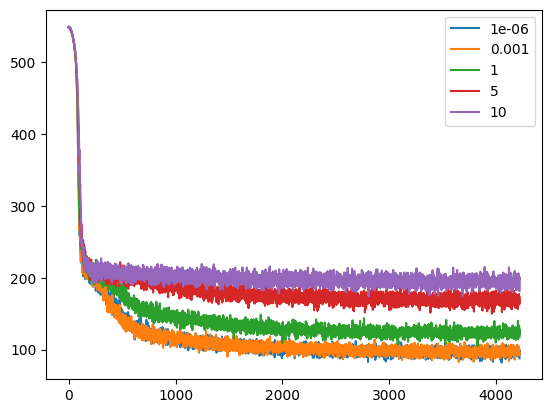

In [19]:
import matplotlib.pyplot as plt
for res in results:
    plt.plot(res['losses'], label=res['beta']);
plt.legend()

In [20]:
for x, _ in trainloader:
    break

x_hat, _ = state.apply_fn(state.params, x, rngs=jax.random.key(0))

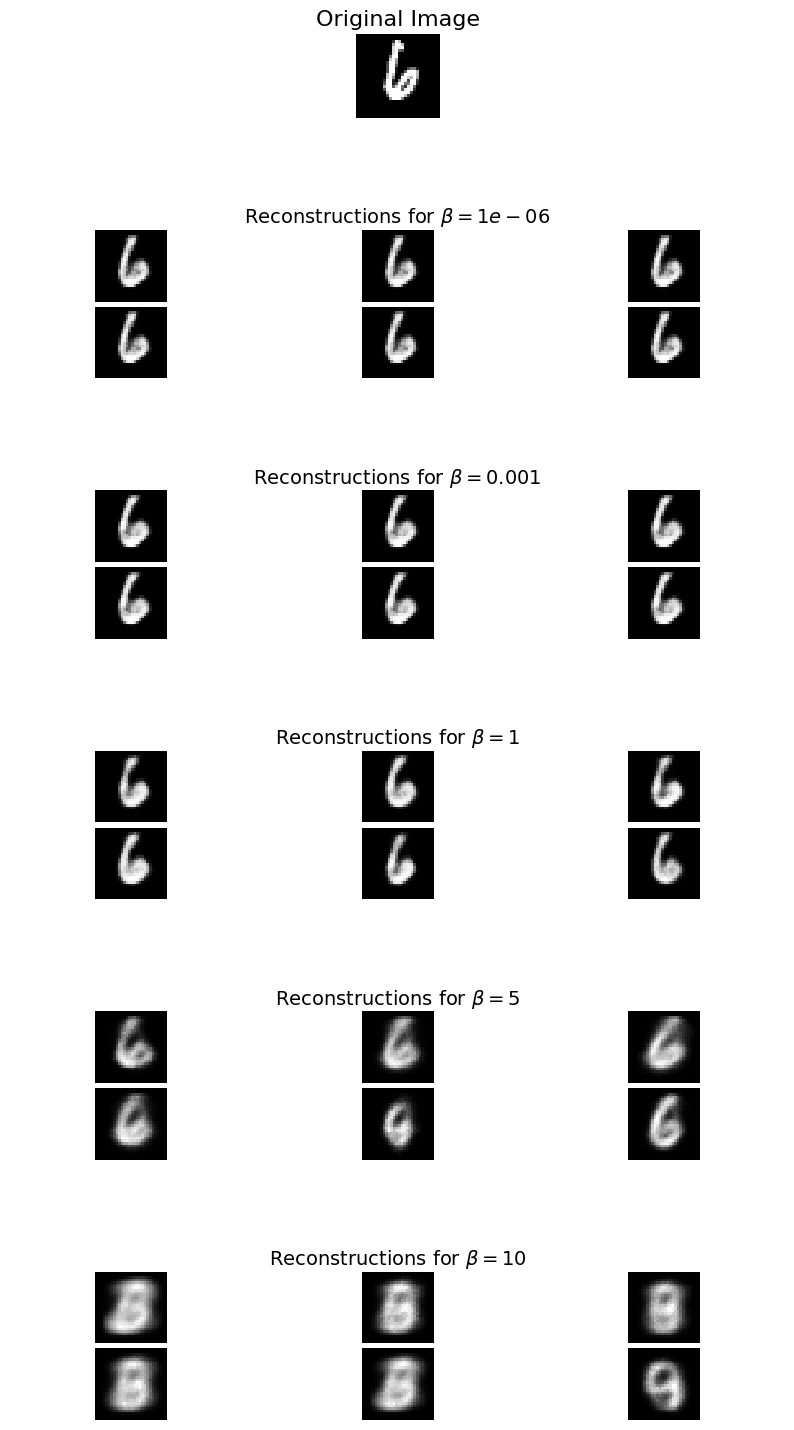

In [22]:
idx = 5

original_img = x[idx]
num_betas = len(results)
num_reconstructions_per_beta = 6 # For a 2x3 grid

recon_key = jax.random.key(0)

# Create the figure
fig = plt.figure(figsize=(10, 3 * num_betas + 3)) # Adjust figsize as needed

# Main GridSpec: 1 column, rows for original + beta sections
outer_gs = fig.add_gridspec(num_betas + 1, 1, height_ratios=[1.5] + [3] * num_betas, hspace=0.6)

# --- Plot Original Image ---
ax_orig = fig.add_subplot(outer_gs[0, 0])
ax_orig.imshow(original_img, cmap='gray', interpolation='nearest') # Adjust cmap if not grayscale
ax_orig.set_title("Original Image", fontsize=16)
ax_orig.axis('off')

# --- Plot Reconstructions for each Beta ---
for i, result_data in enumerate(results):
    beta = result_data['beta']
    state = result_data['state'] # This is your Flax TrainState or equivalent

    # Create a nested GridSpec for this beta's title and 2x3 reconstructions
    inner_gs = outer_gs[i+1, 0].subgridspec(3, 3, hspace=0.1, wspace=0.1, height_ratios=[0.2, 1, 1])

    # Beta title
    ax_beta_title = fig.add_subplot(inner_gs[0, :]) # Span all columns for title
    ax_beta_title.text(0.5, 0.5, f"Reconstructions for $\\beta = {beta}$",
                       horizontalalignment='center', verticalalignment='center', fontsize=14)
    ax_beta_title.axis('off')

    # 2x3 grid for reconstructions
    for j in range(num_reconstructions_per_beta):
        row = 1 + (j // 3) # Determine row in the 2x3 grid (either 1 or 2)
        col = j % 3        # Determine col in the 2x3 grid

        ax_recon = fig.add_subplot(inner_gs[row, col])
        # reconstructed_img = reconstruct_image(state, original_img)
        recon_key, subkey = random.split(recon_key)
        x_hat, _ = state.apply_fn(state.params, x, rngs=subkey)
        reconstructed_img = x_hat[idx]
        ax_recon.imshow(reconstructed_img, cmap='gray', interpolation='nearest') # Adjust cmap
        ax_recon.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to prevent main title overlap if needed
plt.show()